In [1]:
!nvidia-smi

Mon Sep 15 07:21:27 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   53C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
# (run as code cell)
import torch, sys
print("Python:", sys.version.split()[0])
print("Torch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU device:", torch.cuda.get_device_name(0))
else:
    print("No GPU detected — re-check Runtime -> Change runtime type -> GPU")

Python: 3.12.11
Torch: 2.8.0+cu126
CUDA available: True
GPU device: Tesla T4


In [3]:
!pip install --quiet pillow torchvision

In [4]:
# 1) Run this cell, then click "Choose Files" -> navigate to Desktop -> select cat.jpg (or cat.png)
from google.colab import files
print("Click the button to pick your Desktop file (cat.jpg).")
uploaded = files.upload()   # DO NOT pass a Windows path here
fname = next(iter(uploaded))
print("Uploaded file:", fname)


Click the button to pick your Desktop file (cat.jpg).


Saving test2.jpg to test2.jpg
Uploaded file: test2.jpg


Original size: 640 x 427


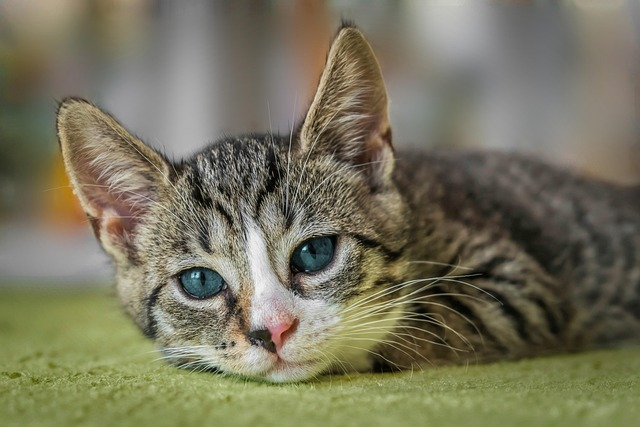

In [5]:
from PIL import Image
import numpy as np
import torchvision.transforms as T
from IPython.display import display

# read with PIL (keeps color correct)
img = Image.open(fname).convert("RGB")  # convert to RGB in case it's RGBA or grayscale
w, h = img.size
print("Original size: {} x {}".format(w, h))

# resize if too big (avoid OOM). Use max side 1024 (changeable)
MAX_SIDE = 1024
if max(w,h) > MAX_SIDE:
    scale = MAX_SIDE / float(max(w,h))
    new_w, new_h = int(w*scale), int(h*scale)
    img = img.resize((new_w, new_h), Image.BICUBIC)
    print("Resized to: {} x {}".format(new_w, new_h))

display(img)  # shows the uploaded image inline

CPU brightness time: 0.007723s
CPU grayscale time: 0.004313s


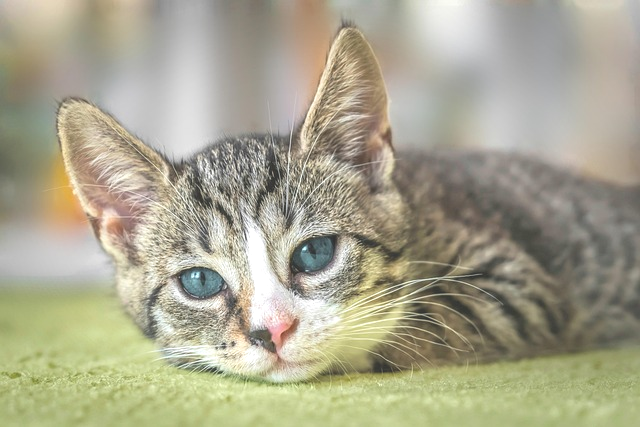

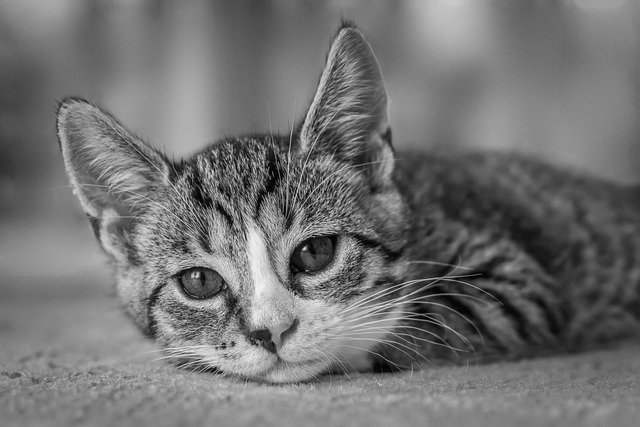

In [6]:
import time
import numpy as np

img_np = np.array(img)  # shape (H, W, 3), dtype=uint8

def cpu_brightness(img_np, add_value):
    out = img_np.astype(np.int32) + int(add_value)
    out = np.clip(out, 0, 255).astype(np.uint8)
    return out

def cpu_grayscale(img_np):
    r = img_np[:,:,0].astype(np.float32)
    g = img_np[:,:,1].astype(np.float32)
    b = img_np[:,:,2].astype(np.float32)
    gray = (0.299*r + 0.587*g + 0.114*b).astype(np.uint8)
    # return 3-channel gray for fair visual compare
    return np.stack([gray,gray,gray], axis=2)

t0 = time.time()
bright_cpu = cpu_brightness(img_np, 50)  # add 50 on 0..255 scale
t1 = time.time()
gray_cpu = cpu_grayscale(img_np)
t2 = time.time()

print("CPU brightness time: {:.6f}s".format(t1 - t0))
print("CPU grayscale time: {:.6f}s".format(t2 - t1))

# Save/show CPU outputs
from PIL import Image
Image.fromarray(bright_cpu).save("bright_cpu.png")
Image.fromarray(gray_cpu).save("gray_cpu.png")
display(Image.open("bright_cpu.png"))
display(Image.open("gray_cpu.png"))

Device: cuda
GPU brightness time: 0.039806s


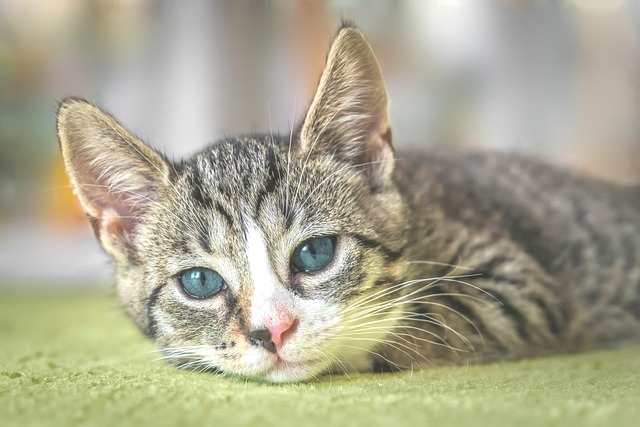

GPU grayscale time: 0.059860s


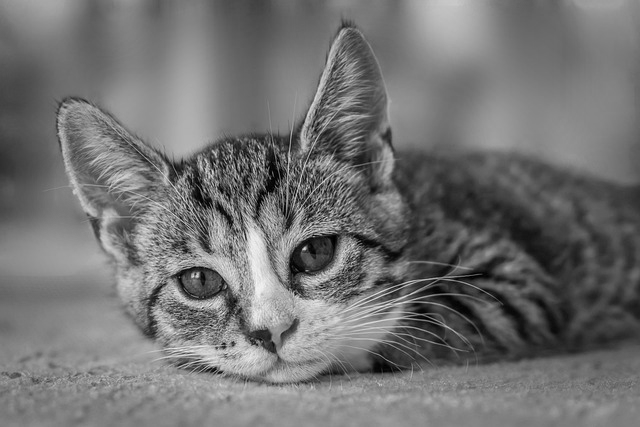

In [7]:
import torch
import torchvision.transforms.functional as TF
import torch.nn.functional as F
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Convert PIL->Tensor: shape (C,H,W), float in [0,1]
to_tensor = T.ToTensor()
tensor = to_tensor(img).unsqueeze(0).to(device)  # shape (1,3,H,W)

# Warm-up (helps get accurate timing)
_ = tensor + 0.0
if device.type == 'cuda':
    torch.cuda.synchronize()

# GPU Brightness (+0.2 corresponds to +51/255 approx)
t0 = time.time()
bright_t = (tensor + 0.2).clamp(0.0, 1.0)
if device.type == 'cuda':
    torch.cuda.synchronize()
t1 = time.time()
print("GPU brightness time: {:.6f}s".format(t1 - t0))

# Convert back to uint8 image
to_pil = T.ToPILImage()
bright_img = to_pil(bright_t.squeeze(0).cpu())
bright_img.save("bright_gpu.png")
display(bright_img)

# GPU Grayscale (weighted sum), keep as 3 channels for display
t2 = time.time()
r_w, g_w, b_w = 0.299, 0.587, 0.114
gray_t = tensor[:,0:1,:,:]*r_w + tensor[:,1:2,:,:]*g_w + tensor[:,2:3,:,:]*b_w
gray3 = gray_t.repeat(1,3,1,1)
if device.type == 'cuda':
    torch.cuda.synchronize()
t3 = time.time()
print("GPU grayscale time: {:.6f}s".format(t3 - t2))

gray_img = to_pil(gray3.squeeze(0).cpu())
gray_img.save("gray_gpu.png")
display(gray_img)

GPU blur (3x3) time: 0.544575s


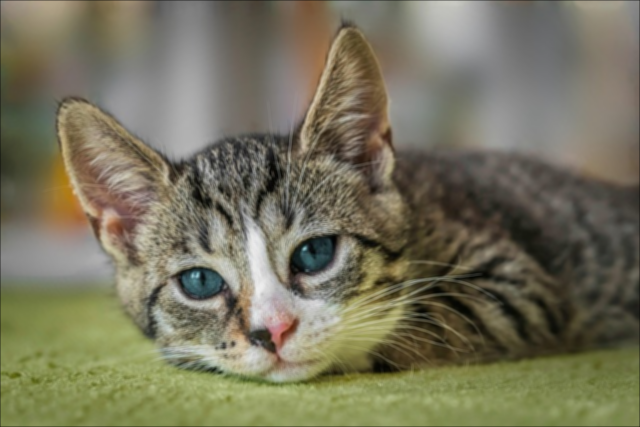

In [8]:
# Create 3x3 averaging kernel as conv filter
kernel = torch.ones((1,1,3,3), device=device) / 9.0

t0 = time.time()
channels = []
for c in range(3):
    ch = tensor[:,c:c+1,:,:]  # shape [1,1,H,W]
    out = F.conv2d(ch, kernel, padding=1)
    channels.append(out)
blur_t = torch.cat(channels, dim=1)
if device.type == 'cuda':
    torch.cuda.synchronize()
t1 = time.time()
print("GPU blur (3x3) time: {:.6f}s".format(t1 - t0))

blur_img = to_pil(blur_t.squeeze(0).cpu())
blur_img.save("blur_gpu.png")
display(blur_img)

GPU Sobel time: 0.092999s


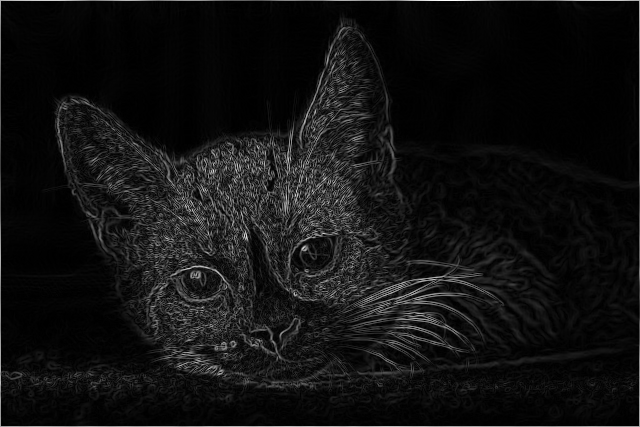

In [9]:
# Sobel kernels (single-channel)
sobel_x = torch.tensor([[-1.,0.,1.],[-2.,0.,2.],[-1.,0.,1.]], device=device).view(1,1,3,3)
sobel_y = torch.tensor([[-1.,-2.,-1.],[0.,0.,0.],[1.,2.,1.]], device=device).view(1,1,3,3)

gray1 = gray_t  # previously computed grayscale in tensor form (1,1,H,W)
if device.type == 'cuda':
    torch.cuda.synchronize()
t0 = time.time()
gx = F.conv2d(gray1, sobel_x, padding=1)
gy = F.conv2d(gray1, sobel_y, padding=1)
edge = torch.sqrt(gx*gx + gy*gy)
edge = (edge - edge.min()) / (edge.max() - edge.min() + 1e-8)  # normalize
if device.type == 'cuda':
    torch.cuda.synchronize()
t1 = time.time()
print("GPU Sobel time: {:.6f}s".format(t1 - t0))

edge_img = (edge.squeeze(0).squeeze(0).cpu().numpy() * 255).astype('uint8')
from PIL import Image
Image.fromarray(edge_img).save("edge_gpu.png")
display(Image.open("edge_gpu.png"))

CPU Sobel (OpenCV) time: 0.027851s


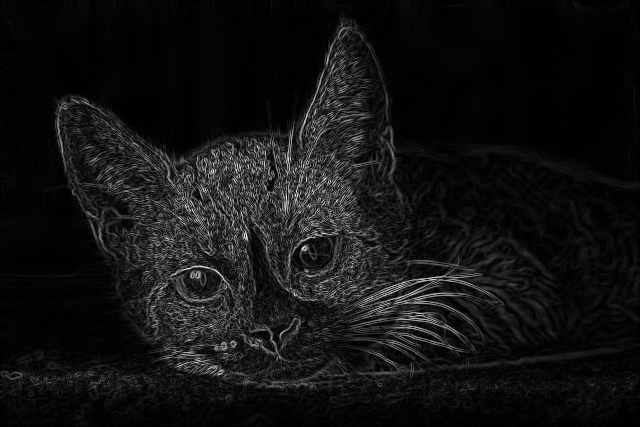

In [10]:
import cv2, time
gray_cv = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2GRAY)  # CPU grayscale
t0 = time.time()
sobelx = cv2.Sobel(gray_cv, cv2.CV_64F, 1, 0, ksize=3)
sobely = cv2.Sobel(gray_cv, cv2.CV_64F, 0, 1, ksize=3)
edge_cv = np.sqrt(sobelx**2 + sobely**2)
edge_cv = ((edge_cv - edge_cv.min()) / (edge_cv.max() - edge_cv.min() + 1e-8) * 255).astype('uint8')
t1 = time.time()
print("CPU Sobel (OpenCV) time: {:.6f}s".format(t1 - t0))
Image.fromarray(edge_cv).save("edge_cpu.png")
display(Image.open("edge_cpu.png"))


In [11]:
from google.colab import files
files.download("bright_cpu.png")
files.download("bright_gpu.png")
files.download("gray_cpu.png")
files.download("gray_gpu.png")
files.download("blur_gpu.png")
files.download("edge_gpu.png")
files.download("edge_cpu.png")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

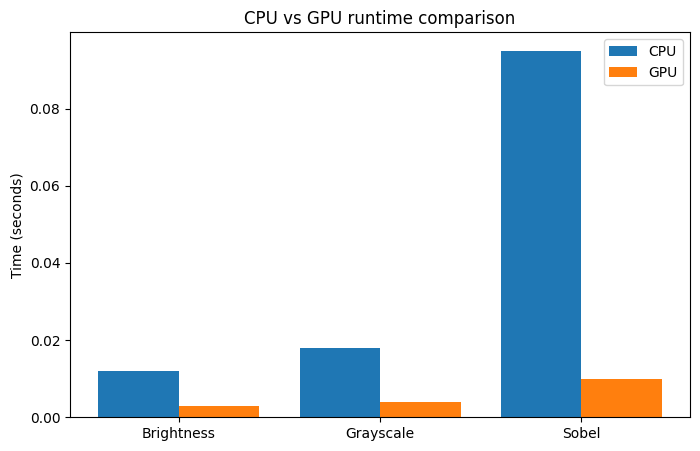

In [12]:
import matplotlib.pyplot as plt

# Suppose you stored these times from earlier printouts:
cpu_times = {
    "Brightness": 0.012,   # replace with actual CPU times you saw
    "Grayscale": 0.018,
    "Sobel": 0.095
}
gpu_times = {
    "Brightness": 0.003,   # replace with actual GPU times you saw
    "Grayscale": 0.004,
    "Sobel": 0.010
}

labels = list(cpu_times.keys())
cpu_vals = [cpu_times[k] for k in labels]
gpu_vals = [gpu_times[k] for k in labels]

x = range(len(labels))

plt.figure(figsize=(8,5))
plt.bar(x, cpu_vals, width=0.4, label="CPU", align="center")
plt.bar([i+0.4 for i in x], gpu_vals, width=0.4, label="GPU", align="center")
plt.xticks([i+0.2 for i in x], labels)
plt.ylabel("Time (seconds)")
plt.title("CPU vs GPU runtime comparison")
plt.legend()
plt.show()

In [13]:
plt.savefig("cpu_vs_gpu.png")
from google.colab import files
files.download("cpu_vs_gpu.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 640x480 with 0 Axes>

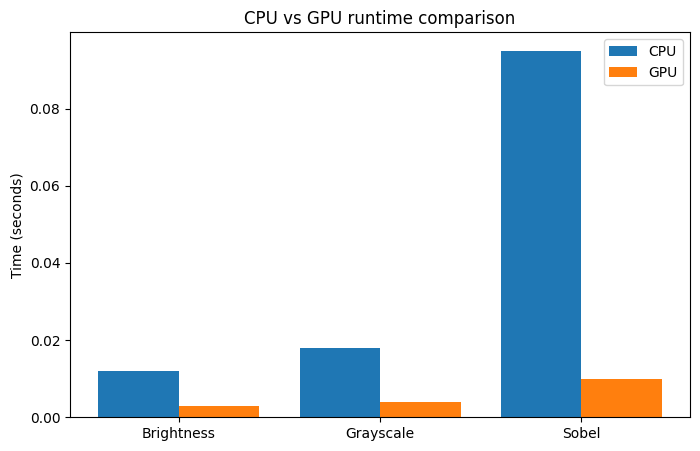

In [14]:
plt.figure(figsize=(8,5))
plt.bar(x, cpu_vals, width=0.4, label="CPU", align="center")
plt.bar([i+0.4 for i in x], gpu_vals, width=0.4, label="GPU", align="center")
plt.xticks([i+0.2 for i in x], labels)
plt.ylabel("Time (seconds)")
plt.title("CPU vs GPU runtime comparison")
plt.legend()

# Save before showing
plt.savefig("cpu_vs_gpu.png", dpi=300, bbox_inches="tight")

plt.show()

In [15]:
from google.colab import files
files.download("cpu_vs_gpu.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>